# CrisisNLP: Classifying and Normalizing Twitter Messages for Disaster Response

# Overview

This notebook is based on the paper "Twitter as a Lifeline: Human-annotated Twitter Corpora for NLP of Crisis-related Messages" by Imran et al. The study presents a large-scale dataset of over 52 million crisis-related tweets collected during 19 major disasters from 2013–2015 out of which I've used 9 of those datasets. It includes human-annotated corpora for multiclass classification and text normalization tasks, making it highly valuable for natural language processing in emergency response scenarios.

In this notebook, we:

 - Explore the annotated datasets,

 - Train supervised models (Naive Bayes, LSTM) to classify crisis tweets,

 - Utilize GLOVE embeddings, and

 - Demonstrate techniques for normalizing informal or noisy Twitter text (OOV terms).

These tools aim to support timely and effective information extraction from social media during disasters to aid humanitarian efforts.



# Importing libraries and dataset

In [39]:
import numpy as np
import pandas as pd

from io import open
import os, string, random, time, math
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

# Try a more specific seaborn style name
plt.style.use('seaborn-v0_8')

In [6]:
df0 = pd.read_csv('/content/2015_Nepal_Earthquake_en_CF_labeled_data.tsv',sep = '\t')
df1 = pd.read_csv('/content/2013_Pakistan_eq_CF_labeled_data.tsv',sep = '\t')
df2 = pd.read_csv('/content/2014_California_Earthquake_CF_labeled_data.tsv',sep = '\t')
df4 = pd.read_csv('/content/2014_Chile_Earthquake_en_CF_labeled_data.tsv', sep = '\t')
df5 = pd.read_csv('/content/2014_Hurricane_Odile_Mexico_en_CF_labeled_data.tsv', sep = '\t')
df6 = pd.read_csv('/content/2014_India_floods_CF_labeled_data.tsv', sep = '\t')
df8 = pd.read_csv('/content/2014_Pakistan_floods_CF_labeled_data.tsv', sep = '\t')
df9 = pd.read_csv('/content/2014_Philippines_Typhoon_Hagupit_en_CF_labeled_data.tsv', sep = '\t')
df10 = pd.read_csv('/content/2015_Cyclone_Pam_en_CF_labeled_data.tsv', sep = '\t')

df = pd.concat([df0, df1, df2, df4, df5, df6, df8, df9, df10])
df.head()

,tweet_id,tweet_text,label
0,'592326564110585856',RT @divyaconnects: Reached #Kathmandu finally!...,other_useful_information
1,'592616512642420737',fears for Foreigners missing in Nepal earthqua...,missing_trapped_or_found_people
2,'592686635520827393',"RT @ParisBurned: 3,700 people dead is absolute...",injured_or_dead_people
3,'593301431366635520',Earthquake in Nepal - Please help Kapil #crowd...,donation_needs_or_offers_or_volunteering_services
4,'592590231519555584',Nepal’s Slowing Economy Set for Freefall Witho...,other_useful_information


In [7]:
labels = list(df.label.unique())
labels

['other_useful_information',
 'missing_trapped_or_found_people',
 'injured_or_dead_people',
 'donation_needs_or_offers_or_volunteering_services',
 'sympathy_and_emotional_support',
 'not_related_or_irrelevant',
 'caution_and_advice',
 'displaced_people_and_evacuations',
 'infrastructure_and_utilities_damage']

In [8]:
df.label.value_counts()

,count
label,
other_useful_information,5165
donation_needs_or_offers_or_volunteering_services,2452
injured_or_dead_people,2321
not_related_or_irrelevant,2230
sympathy_and_emotional_support,1887
infrastructure_and_utilities_damage,1394
caution_and_advice,1011
displaced_people_and_evacuations,547
missing_trapped_or_found_people,375


# Cleaning & Processing data

## Tokenization


In [10]:
import nltk
from nltk.tokenize import TweetTokenizer
from sklearn.preprocessing import LabelEncoder

data = []
tokenizer = TweetTokenizer(reduce_len=True)
X = df['tweet_text'].tolist()
Y = df['label'].tolist()

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(Y)

for x, y in zip(X, encoded_labels):
  data.append((tokenizer.tokenize(x), y))

data[:5]

[(['RT',
   '@divyaconnects',
   ':',
   'Reached',
   '#Kathmandu',
   'finally',
   '!',
   'Lots',
   'of',
   'Indians',
   'stranded',
   'at',
   'the',
   'airport',
   '#NepalQuake',
   '@BBCHindi',
   'http://t.co/fRpbU9aCKZ'],
  np.int64(7)),
 (['fears',
   'for',
   'Foreigners',
   'missing',
   'in',
   'Nepal',
   'earthquake',
   'as',
   'death',
   'toll',
   'soars',
   ':'],
  np.int64(5)),
 (['RT',
   '@ParisBurned',
   ':',
   '3,700',
   'people',
   'dead',
   'is',
   'absolutely',
   'devastating',
   'for',
   'a',
   'country',
   'that',
   'is',
   'the',
   'size',
   'of',
   'Oklahoma',
   'on',
   'the',
   'map',
   '.',
   '#Nepal'],
  np.int64(4)),
 (['Earthquake',
   'in',
   'Nepal',
   '-',
   'Please',
   'help',
   'Kapil',
   '#crowdfunding',
   'fundrazr',
   'Support',
   'and',
   'Retweet',
   'http://t.co/mFEyQ85js9',
   'via',
   'MechanismOfWar'],
  np.int64(2)),
 (['Nepal',
   '’',
   's',
   'Slowing',
   'Economy',
   'Set',
   'for',

## Lemmatization & Cleaning

In [11]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [12]:
from nltk.tag import pos_tag
nltk.download('averaged_perceptron_tagger_eng') # Ensure resource is downloaded
pos_tag(data[0][0])

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


[('RT', 'JJ'),
 ('@divyaconnects', 'NNS'),
 (':', ':'),
 ('Reached', 'VBN'),
 ('#Kathmandu', 'NNP'),
 ('finally', 'RB'),
 ('!', '.'),
 ('Lots', 'NNP'),
 ('of', 'IN'),
 ('Indians', 'NNPS'),
 ('stranded', 'VBN'),
 ('at', 'IN'),
 ('the', 'DT'),
 ('airport', 'NN'),
 ('#NepalQuake', 'NNP'),
 ('@BBCHindi', 'NNP'),
 ('http://t.co/fRpbU9aCKZ', 'NN')]

In [13]:
import re
import string
from nltk.corpus import stopwords
import nltk
from nltk.tag import pos_tag
from nltk.stem import WordNetLemmatizer

nltk.download('averaged_perceptron_tagger_eng') # Ensure resource is downloaded
nltk.download('stopwords') # Ensure stopwords are downloaded
nltk.download('wordnet') # Ensure wordnet is downloaded

def remove_noise(tweet_tokens):
  cleaned_tokens = []
  for text, tag in pos_tag(tweet_tokens):
    review = re.sub(r'http\S+|www|S+', '', text) # remove URL's
    review = re.sub(r'@\w+','', review) # remove user mentions
    review = re.sub(r'#|RT|:', '',review) # remove Hastags
    review = review.lower()

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    if tag.startswith('NN'):
      pos = 'n'
    elif tag.startswith('VB'):
      pos = 'v'
    else:
      pos = 'a'
    token = lemmatizer.lemmatize(review, pos)

    # Remove stopwords and stem
    stop_words = set(stopwords.words('english'))
    if token not in stop_words and token not in string.punctuation:
        cleaned_tokens.append(token)

  return cleaned_tokens

print(remove_noise(data[0][0]))

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


['reach', 'kathmandu', 'finally', 'lot', 'indian', 'strand', 'airport', 'nepalquake']


# Data Visualizaton

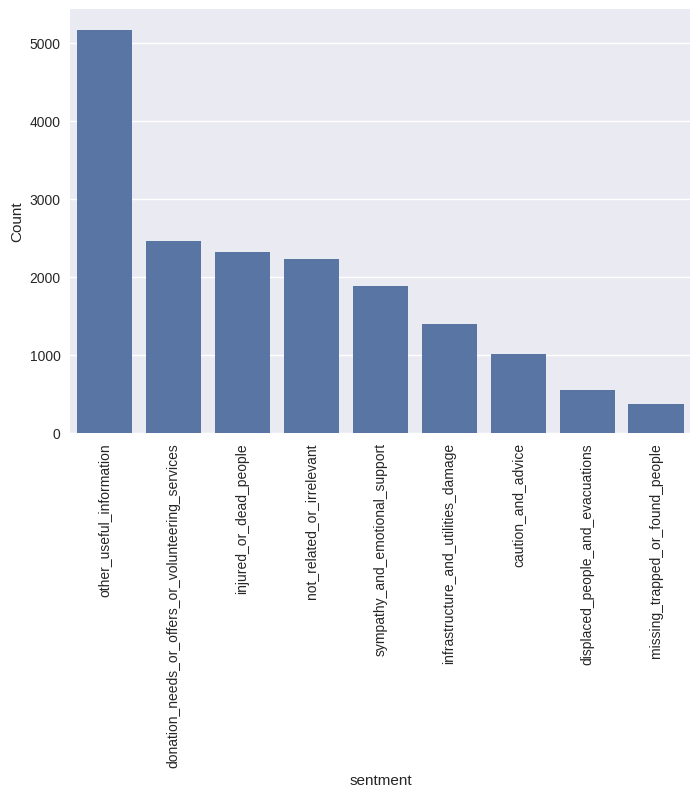

In [40]:
sns.barplot(x = df.label.value_counts().index, y = df.label.value_counts())
plt.xticks(rotation=90)
plt.xlabel('sentment')
plt.ylabel('Count')
plt.show()

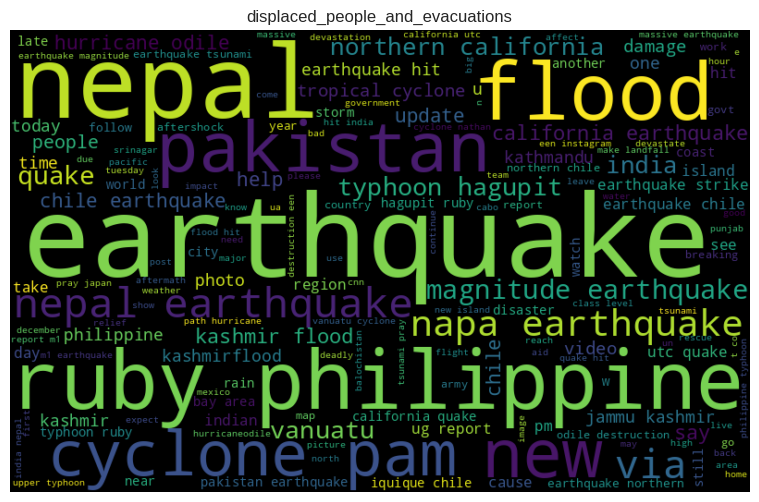

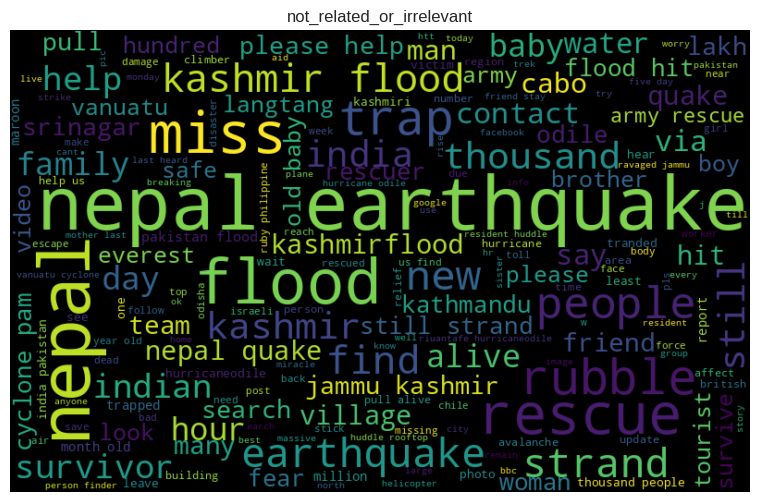

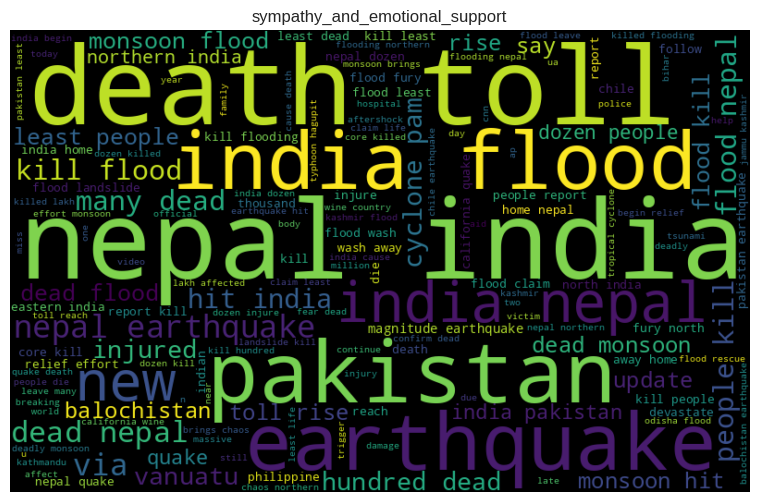

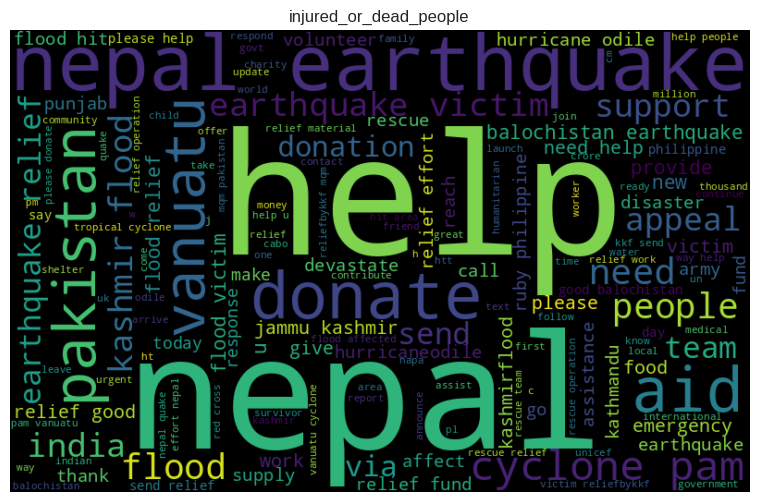

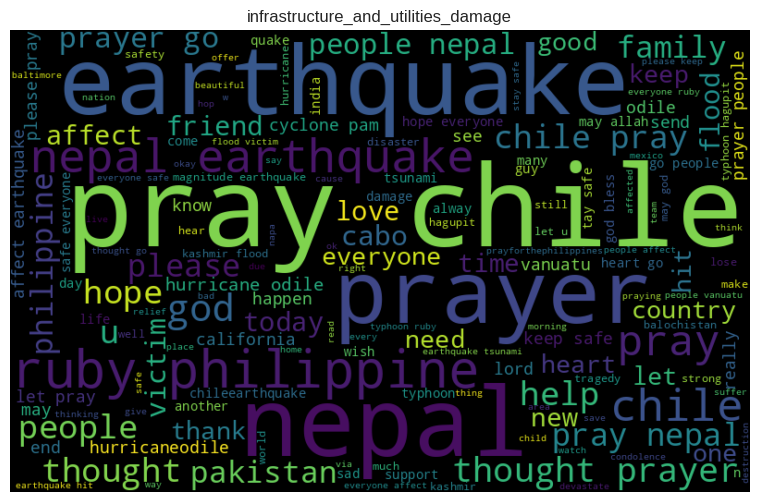

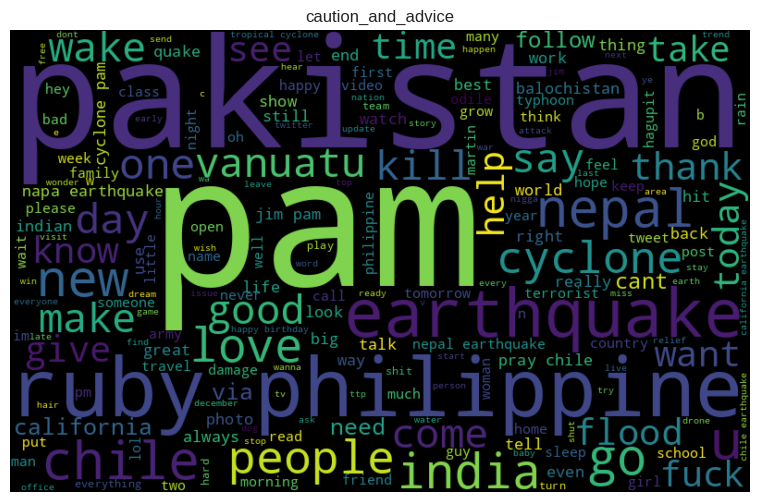

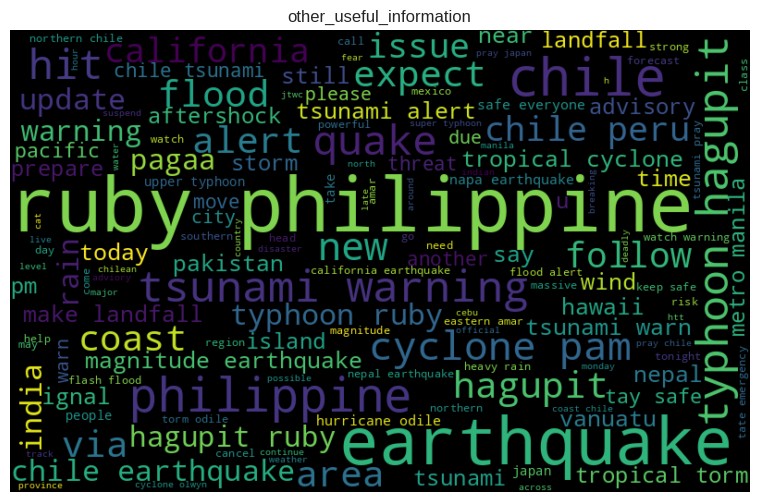

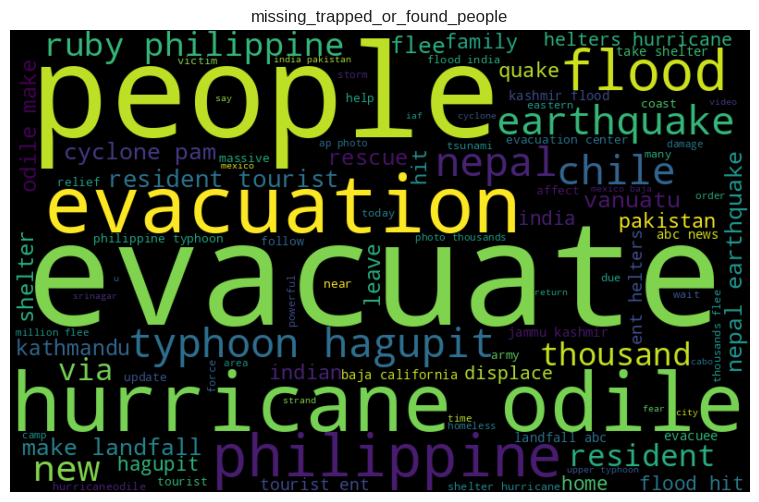

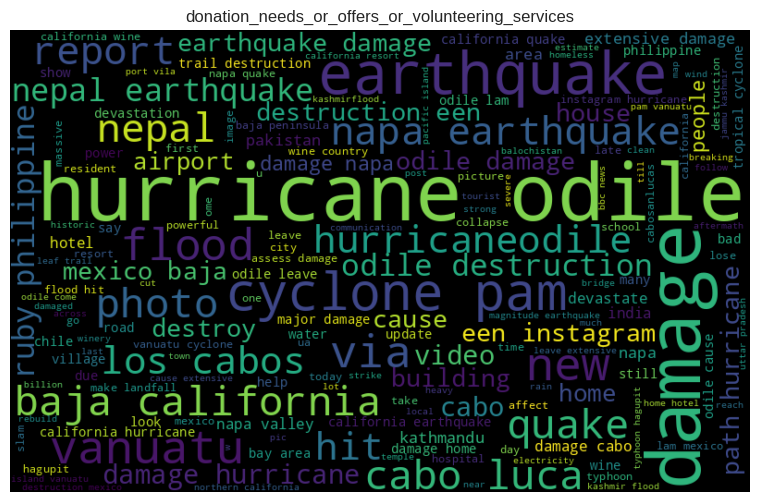

In [41]:
from wordcloud import WordCloud
from collections import defaultdict

list_token_map = defaultdict(list)

for tokens, label in cleaned_token_list:
  list_token_map[labels[label]].extend(tokens)

for label, tokens in list_token_map.items():
  text = ' '.join(tokens)
  wordcloud_title = WordCloud(width=800, height=500, random_state=45, min_font_size=10).generate(text)
  plt.figure(figsize=(12,6))
  plt.imshow(wordcloud_title, interpolation='bilinear')
  plt.axis('off')
  plt.title(str(label))
  plt.show()

# Model: Naive Bayes

## Getting the data ready for modelling

In [14]:
def list_to_dict(cleaned_tokens):
  return dict([token, True] for token in cleaned_tokens)

cleaned_token_list = []
for tokens, label in data:
  cleaned_token_list.append((remove_noise(tokens), label))

final_data = []
for tokens, label in cleaned_token_list:
  final_data.append((list_to_dict(tokens), label))

final_data[:5]

[({'reach': True,
   'kathmandu': True,
   'finally': True,
   'lot': True,
   'indian': True,
   'strand': True,
   'airport': True,
   'nepalquake': True},
  np.int64(7)),
 ({'fear': True,
   'foreigner': True,
   'miss': True,
   'nepal': True,
   'earthquake': True,
   'death': True,
   'toll': True,
   'soar': True},
  np.int64(5)),
 ({'3,700': True,
   'people': True,
   'dead': True,
   'absolutely': True,
   'devastate': True,
   'country': True,
   'size': True,
   'oklahoma': True,
   'map': True,
   'nepal': True},
  np.int64(4)),
 ({'earthquake': True,
   'nepal': True,
   'please': True,
   'help': True,
   'kapil': True,
   'crowdfunding': True,
   'fundrazr': True,
   'upport': True,
   'retweet': True,
   'via': True,
   'mechanismofwar': True},
  np.int64(2)),
 ({'nepal': True,
   '’': True,
   'low': True,
   'economy': True,
   'et': True,
   'freefall': True,
   'without': True,
   'world': True,
   'help': True,
   'via': True},
  np.int64(7))]

## Splitting the data

In [14]:
random.Random(45).shuffle(final_data)

trim_index = int(len(final_data) * 0.9)

train_data = final_data[:trim_index]
test_data = final_data[trim_index:]

## Training and Testing the data

In [93]:
from time import time
start_time = time()

from nltk import classify
from nltk import NaiveBayesClassifier
classifier = NaiveBayesClassifier.train(train_data)

# Output the model accuracy on the train and test data
print('Accuracy on train data:', classify.accuracy(classifier, train_data))
print('Accuracy on test data:', classify.accuracy(classifier, test_data))

# Output the words that provide the most information about the sentiment of a tweet.
# These are words that are heavily present in one sentiment group and very rarely present in the other group.
print(classifier.show_most_informative_features(20))

print('\nCPU Time:', time() - start_time)

Accuracy on train data: 0.6765084944346808
Accuracy on test data: 0.5830258302583026
Most Informative Features
              evacuation = True                1 : 6      =    209.0 : 1.0
                    trap = True                5 : 2      =    185.8 : 1.0
                  rubble = True                5 : 2      =    180.8 : 1.0
                resident = True                1 : 6      =    173.0 : 1.0
                  prayer = True                8 : 7      =    157.9 : 1.0
                    dead = True                4 : 0      =    147.1 : 1.0
                    flee = True                1 : 4      =    144.9 : 1.0
                 helters = True                1 : 7      =    144.0 : 1.0
                    kill = True                4 : 2      =    143.1 : 1.0
                everyone = True                8 : 4      =    137.9 : 1.0
                     180 = True                4 : 7      =    136.7 : 1.0
                   dozen = True                4 : 7      =    1

In [ ]:
tweet = 'Im trapped here. Help!'
c = remove_noise(tokenizer.tokenize(tweet))
classifier.classify(dict([token, True] for token in c))

np.int64(5)

# Model: LSTM

In [94]:
# from google.colab import drive
# drive.mount('/content/drive')

# First time only: download and unzip in Drive
# !wget -P "/content/drive/MyDrive/glove_data" http://nlp.stanford.edu/data/glove.6B.zip
# !unzip "/content/drive/MyDrive/glove_data/glove.6B.zip" -d "/content/drive/MyDrive/glove_data"


In [15]:
from google.colab import drive
drive.mount('/content/drive')

!cp /content/drive/MyDrive/glove_data/glove.6B.50d.txt .

Mounted at /content/drive


## Word Embeddings: GLOVE

In [17]:
def read_glove_vecs(glove_file):
    with open(glove_file, 'r', encoding='utf8') as f:
      words = set()
      word_to_vec = {}
      for line in f:
        line = line.strip().split()
        word = line[0]
        words.add(word)
        word_to_vec[word] = np.array(line[1:], dtype=np.float64)
      i=1
      word_to_index = {}
      index_to_word = {}
      for w in sorted(words):
        word_to_index[w] = i
        index_to_word[i] = w
        i+=1
      return word_to_index, index_to_word, word_to_vec

In [19]:
word_to_index, index_to_word, word_to_vec = read_glove_vecs('glove.6B.50d.txt')

## Data Transformation

In [20]:
def cleared(word):
  res = ''
  prev = None
  for i in word:
    if i == prev:
      continue
    else:
      prev = i
      res += i
  return res

unk = []
UNKS = []

def sentence_to_indecies(sentence_words, word_to_index, max_len, k):
  for i, word in enumerate(sentence_words):
    try:
      index = word_to_index[word]
    except:
      UNKS.append(word)
      word = cleared(word)
      try:
        index = word_to_index[word]
      except:
        index = word_to_index['unk']
        unk.append(word)
    X[k, i] = index

list_len = [len(i) for i,j in cleaned_token_list]
max_len = max(list_len)
print('max_len:', max_len)

X = np.zeros((len(cleaned_token_list), max_len))
Y = np.zeros((len(cleaned_token_list), 1))

for i, (tokens, label) in enumerate(cleaned_token_list):
  sentence_to_indecies(tokens, word_to_index, max_len, i)
  Y[i] = label

print(X[:5])
print(Y[:5])

max_len: 41
[[302170. 203691. 148356. 225985. 189140. 344219.  49231. 372306.      0.
       0.      0.      0.      0.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.]
 [146098. 151516. 246253. 259147. 132523. 118337. 361443. 336156.      0.
       0.      0.      0.      0.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.]
 [ 22545. 280944. 118188.  44787. 122409. 110432. 333429. 268872. 233795.
  259147.      0.      0.      0.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.      0.      0.
       0.     

## Creating Embedding layer

In [98]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout

def pretrained_embedding_layer(word_to_vec_map, word_to_index, max_len):
    vocab_len = len(word_to_index) + 1
    emb_dim = word_to_vec_map["unk"].shape[0] #50

    emb_matrix = np.zeros((vocab_len, emb_dim))

    for word, idx in word_to_index.items():
        emb_matrix[idx, :] = word_to_vec_map[word]

    embedding_layer = Embedding(vocab_len, emb_dim, trainable=False, input_shape=(max_len,))
    embedding_layer.build((None,))
    embedding_layer.set_weights([emb_matrix])

    return embedding_layer

## Training and Testing the Model

In [ ]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout

In [99]:
keras.backend.clear_session()

model1 = Sequential()

model1.add(pretrained_embedding_layer(word_to_vec, word_to_index, max_len))
model1.add(Bidirectional(LSTM(units=128, return_sequences=True)))
model1.add(Bidirectional(LSTM(units=128, return_sequences=False)))
model1.add(Dense(units=len(labels), activation='softmax'))

model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 39, 50)         │    20,000,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 39, 256)        │       183,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,610,482 (78.62 MB)

 Trainable params: 610,432 (2.33 MB)

 Non-trainable params: 20,000,050 (76.29 MB)

In [100]:
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) # using binary cross entropy for loss and adam as an optimizer for the model
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0, stratify=Y)

In [101]:
from tensorflow.keras.utils import to_categorical

# One-hot encode the target labels
Y_train_one_hot = to_categorical(Y_train, num_classes=len(labels))
Y_test_one_hot = to_categorical(Y_test, num_classes=len(labels))

# Capture the training history
history = model1.fit(X_train, Y_train_one_hot, validation_data=(X_test, Y_test_one_hot), epochs = 30, batch_size = 128, shuffle=True)

Epoch 1/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - accuracy: 0.2101 - loss: 0.2043 - val_accuracy: 0.2972 - val_loss: 0.0231
Epoch 2/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.2931 - loss: 0.0230 - val_accuracy: 0.2972 - val_loss: 0.0228
Epoch 3/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.2981 - loss: 0.0227 - val_accuracy: 0.2972 - val_loss: 0.0225
Epoch 4/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.2914 - loss: 0.0224 - val_accuracy: 0.2972 - val_loss: 0.0220
Epoch 5/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.3140 - loss: 0.0217 - val_accuracy: 0.3426 - val_loss: 0.0208
Epoch 6/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.3524 - loss: 0.0206 - val_accuracy: 0.4261 - val_loss: 0.0199
Epoch 7/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.4763 - loss: 0.0190 - val_accuracy: 0.5762 - val_loss: 0.0173
Epoch 8/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.5750 - loss: 0.0168 - val_accu

## Further Cleaning

Displays the top 50 out-of-vocabulary (OOV) words encountered while mapping tokens to GloVe embeddings.

In [21]:
from collections import Counter
Counter(unk).most_common(50)

[('rubyph', 1151),
 ('nepalearthquake', 541),
 ('prayforchile', 418),
 ('cyclonepam', 284),
 ('nepalquake', 250),
 ('huricaneodile', 245),
 ('kashmirflods', 186),
 ('awaran', 172),
 ('napaquake', 140),
 ('outh', 119),
 ('flod-hit', 116),
 ('walangpasok', 113),
 ("odile's", 111),
 ('tcpam', 102),
 ('rinagar', 95),
 ('→', 94),
 ("let's", 92),
 ('uper', 92),
 ('eptember', 86),
 ('chilearthquake', 85),
 ('【', 80),
 ('】', 79),
 ("nepal's", 77),
 ("can't", 76),
 ('¦', 76),
 ('prayfornepal', 75),
 ('️', 74),
 ('prayfromjapan', 72),
 ('outhern', 72),
 ('🙏', 69),
 ("chile's", 68),
 ('ὤf', 65),
 ('♥', 65),
 ("mexico's", 64),
 ('nepalquakerelief', 63),
 ('❤', 63),
 ('unday', 61),
 ("here's", 57),
 ("india's", 54),
 ('loscabos', 54),
 ("california's", 51),
 ('😂', 50),
 ('•', 50),
 ('reliefbykf', 49),
 ('typhonhagupit', 49),
 ('pakistanflods', 46),
 ("vanuatu's", 44),
 ('olwyn', 44),
 ("that's", 42),
 ("pakistan's", 42)]

In [102]:
df[df['tweet_text'].str.contains('oraciones')]['tweet_text'] # Trying to make sense of the OOV words

,tweet_text
22,"Mis oraciones para el pueblo chileno ""@YourAno..."
735,RT @rafaeldlf: my prayers go out to the people...


This function, cleaned(token), performs custom token normalization and correction for noisy or misspelled tokens typically found in tweets.

In [26]:
def cleaned(token):
  if token == 'rubyph':
    return 'ruby philippines'

  if token in ['nepalearthquake', 'nepalquake']:
    return 'nepal earthquake'

  if token == 'prayforchile':
    return 'pray for chile'

  if token == 'cyclonepam':
    return 'cyclone pam'

  if token == 'nepalquake':
    return 'nepal earthquake'

  if token == 'huricaneodile':
    return 'hurricane odile'

  if token == 'fuerzachile':
    return 'fuerza chile'

  if token == 'kashmirflods':
    return 'kashmir floods'

  if token == 'napaquake':
    return 'earthquake'

  if token == 'flod-hit':
    return 'flood hit'

  if token == 'walangpasok':
    return 'no classes'

  if token == "odile's":
    return 'odile'

  if token == 'antiago':
    return 'Santiago'

  if token == 'tcpam':
    return 'tropical cyclone pam'

  if token == 'rinagar':
    return 'srinagar'

  if token == "let's":
    return 'let'

  if token == 'uper':
    return 'upper'

  if token == 'chilearthquake':
    return 'chile earthquake'

  if token == 'eptember':
    return 'september'

  if token == "nepal's":
    return 'nepal'

  if token == "prayfornepal":
    return 'pray for nepal'

  if token == "outhern":
    return 'southern'

  if token == "oraciones":
    return 'prayer'

  if token == "prayfromjapan":
    return 'pray from japan'

  if token == "chile's":
    return 'chile'

  if token == "mexico's":
    return 'mexico'

  if token == "nepalquakerelief":
    return 'nepal earthquake relief'

  if token == "unday":
    return 'sunday'

  if token == "here's":
    return 'here'

  if token == "california's":
    return 'california'

  if token == "india's":
    return 'india'

  if token == 'huricaneodile':
    return 'hurricane odile'

  if token == 'kashmirflods':
    return 'kashmir floods'

  if token == 'flood-hit':
    return 'flood hit'

  if token == 'eahquake':
    return 'earthquake'

  if token == "pakistan's":
    return 'pakistan'

  if token == "can't":
    return 'cant'

  if token in ['outh', 'awaran','teremotoenchile','→','【','】','🙏','¦','♥','❤','ὤf','•','😂']:
    return ''

  return token

In [35]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def remove_noise(tweet_tokens):
  cleaned_tokens = []
  for text, tag in pos_tag(tweet_tokens):
    review = re.sub(r'http\S+|www|S+', '', text)
    review = re.sub(r'@\w+', '', review)
    review = re.sub(r'#|RT|:', '', review)
    expanded = cleaned(review.lower())

    for word in expanded.split():
        if tag.startswith('NN'):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'

        token = lemmatizer.lemmatize(word, pos)
        if token not in stop_words and token not in string.punctuation:
            cleaned_tokens.append(token)
  return cleaned_tokens

In [36]:
def cleared(word):
  res = ''
  prev = None
  for i in word:
    if i == prev:
      continue
    else:
      prev = i
      res += i
  return res

unk = []
UNKS = []

def sentence_to_indecies(sentence_words, word_to_index, max_len, k):
  for i, word in enumerate(sentence_words):
    try:
      index = word_to_index[word]
    except:
      UNKS.append(word)
      word = cleared(word)
      try:
        index = word_to_index[word]
      except:
        index = word_to_index['unk']
        unk.append(word)
    X[k, i] = index

cleaned_token_list = []

# Removing noise from all the data, using the newly defined function
for tokens, label in data:
    x = remove_noise(tokens)
    if x:
        cleaned_token_list.append((x, label))

list_len = [len(i) for i,j in cleaned_token_list]
max_len = max(list_len)
print('max_len:', max_len)

X = np.zeros((len(cleaned_token_list), max_len))
Y = np.zeros((len(cleaned_token_list), 1))

for i, (tokens, label) in enumerate(cleaned_token_list):
  sentence_to_indecies(tokens, word_to_index, max_len, i)
  Y[i] = label

print(X[:5])
print(Y[:5])

max_len: 39
[[302170. 203691. 148356. 225985. 189140. 344219.  49231. 259147. 132523.
       0.      0.      0.      0.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.      0.      0.
       0.      0.      0.]
 [146098. 151516. 246253. 259147. 132523. 118337. 361443. 336156.      0.
       0.      0.      0.      0.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.      0.      0.
       0.      0.      0.]
 [ 22545. 280944. 118188.  44787. 122409. 110432. 333429. 268872. 233795.
  259147.      0.      0.      0.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.      0.      0.
       0.      0.      0.]
 [132523. 259147. 2

In [29]:
from collections import Counter
Counter(unk).most_common(50)

[('huricaneodile', 245),
 ('kashmirflods', 186),
 ('chilearthquake', 85),
 ('️', 74),
 ('loscabos', 54),
 ('reliefbykf', 49),
 ('typhonhagupit', 49),
 ('pakistanflods', 46),
 ("vanuatu's", 44),
 ('olwyn', 44),
 ("that's", 42),
 ('uryaray', 41),
 ('<3', 37),
 ('cabosanlucas', 37),
 ('aturday', 36),
 ("there's", 36),
 ('indianews', 36),
 ('pasthour', 36),
 ('♦', 36),
 ('ignal', 36),
 ('uport', 34),
 ('8.2-', 34),
 ('quake-hit', 33),
 ('breakingnews', 33),
 ('kashmirflod', 33),
 ('retwet', 31),
 ("what's", 31),
 ('6.0-', 31),
 ('indh', 30),
 ('indiawithnepal', 29),
 ("today's", 29),
 ('ocial', 29),
 ('pmln', 29),
 ('prayforouthkorea', 29),
 ('pleae', 28),
 ('tates.htp', 28),
 ('😭', 28),
 ('worldnews', 27),
 ('helters', 27),
 ('cyclone-hit', 27),
 ('->', 26),
 ('hmrd', 26),
 ('7.8-', 25),
 ('8/', 25),
 ('ituation', 24),
 ("unday's", 24),
 ('ystem', 24),
 ('katers', 24),
 ('prayforinabung', 24),
 ('✨', 24)]

## Training the Model on Cleaned & Preprocessed Tweet Data


In [57]:
def pretrained_embedding_layer(word_to_vec_map, word_to_index, max_len):
    vocab_len = len(word_to_index) + 1
    emb_dim = word_to_vec_map["unk"].shape[0] #50

    emb_matrix = np.zeros((vocab_len, emb_dim))

    for word, idx in word_to_index.items():
        emb_matrix[idx, :] = word_to_vec_map[word]

    embedding_layer = Embedding(vocab_len, emb_dim, trainable=False, input_shape=(max_len,))
    embedding_layer.build((None,))
    embedding_layer.set_weights([emb_matrix])

    return embedding_layer

In [69]:
keras.backend.clear_session()

model_clean_data = Sequential()

# Directly add the Keras Embedding layer returned by pretrained_embedding_layer
model_clean_data.add(pretrained_embedding_layer(word_to_vec, word_to_index, max_len))


model_clean_data.add(Bidirectional(LSTM(units=128, return_sequences=True)))
model_clean_data.add(Bidirectional(LSTM(units=128, return_sequences=False)))
model_clean_data.add(Dense(units=len(labels), activation='softmax')) # Change units to len(labels) which is 9

model_clean_data.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 39, 50)         │    20,000,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 39, 256)        │       183,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,610,482 (78.62 MB)

 Trainable params: 610,432 (2.33 MB)

 Non-trainable params: 20,000,050 (76.29 MB)

In [70]:
model_clean_data.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [71]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0, stratify=Y)

In [72]:
from tensorflow.keras.utils import to_categorical

# One-hot encode the target labels
Y_train_one_hot = to_categorical(Y_train, num_classes=len(labels))
Y_test_one_hot = to_categorical(Y_test, num_classes=len(labels))

history = model_clean_data.fit(X_train, Y_train_one_hot, validation_data=(X_test, Y_test_one_hot), epochs = 20, batch_size = 128, shuffle=True)

Epoch 1/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - accuracy: 0.3614 - loss: 2.3804 - val_accuracy: 0.6194 - val_loss: 1.1450
Epoch 2/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.6256 - loss: 1.1131 - val_accuracy: 0.6505 - val_loss: 1.0107
Epoch 3/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.6698 - loss: 0.9732 - val_accuracy: 0.6628 - val_loss: 0.9682
Epoch 4/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.7038 - loss: 0.8904 - val_accuracy: 0.6858 - val_loss: 0.9201
Epoch 5/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.7164 - loss: 0.8294 - val_accuracy: 0.6933 - val_loss: 0.8852
Epoch 6/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.7330 - loss: 0.7778 - val_accuracy: 0.7034 - val_loss: 0.8735
Epoch 7/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.7459 - loss: 0.7404 - val_accuracy: 0.7077 - val_loss: 0.8793
Epoch 8/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.7565 - loss: 0.7230 - val_accu

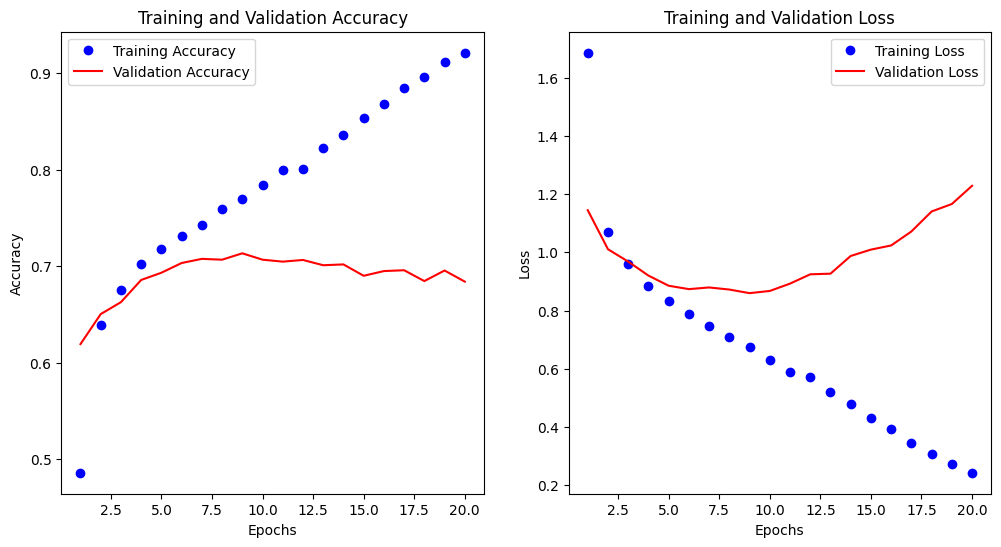

In [73]:
def plot_acc_loss(history):

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo', label = 'Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label = 'Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo', label = 'Training Loss')
    plt.plot(epochs, val_loss, 'r', label = 'Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Pass the captured history object to the function
plot_acc_loss(history)

## Adding Dropout Layers

In [81]:
keras.backend.clear_session()

model_dropout = Sequential()

model_dropout.add(pretrained_embedding_layer(word_to_vec, word_to_index, max_len))
model_dropout.add(Dropout(rate=0.4))
model_dropout.add(Bidirectional(LSTM(units=128, return_sequences=True)))
model_dropout.add(Dropout(rate=0.4))
model_dropout.add(Bidirectional(LSTM(units=128, return_sequences=False)))
model_dropout.add(Dense(units=len(labels), activation='softmax'))

model_dropout.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 39, 50)         │    20,000,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 39, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 39, 256)        │       183,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 39, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,610,482 (78.62 MB)

 Trainable params: 610,432 (2.33 MB)

 Non-trainable params: 20,000,050 (76.29 MB)

In [82]:
model_dropout.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [86]:
from tensorflow.keras.utils import to_categorical

# One-hot encode the target labels
Y_train_one_hot = to_categorical(Y_train, num_classes=len(labels))
Y_test_one_hot = to_categorical(Y_test, num_classes=len(labels))

history = model_dropout.fit(X_train, Y_train_one_hot, validation_data=(X_test, Y_test_one_hot), epochs = 30, batch_size = 128, shuffle=True)

Epoch 1/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.6769 - loss: 0.0123 - val_accuracy: 0.6910 - val_loss: 0.0116
Epoch 2/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.6828 - loss: 0.0121 - val_accuracy: 0.6936 - val_loss: 0.0117
Epoch 3/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.6737 - loss: 0.0122 - val_accuracy: 0.7071 - val_loss: 0.0114
Epoch 4/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.6846 - loss: 0.0119 - val_accuracy: 0.7103 - val_loss: 0.0113
Epoch 5/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.6930 - loss: 0.0116 - val_accuracy: 0.7051 - val_loss: 0.0113
Epoch 6/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.6951 - loss: 0.0116 - val_accuracy: 0.7083 - val_loss: 0.0113
Epoch 7/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.7031 - loss: 0.0115 - val_accuracy: 0.7129 - val_loss: 0.0111
Epoch 8/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.7005 - loss: 0.0113 - val_accu

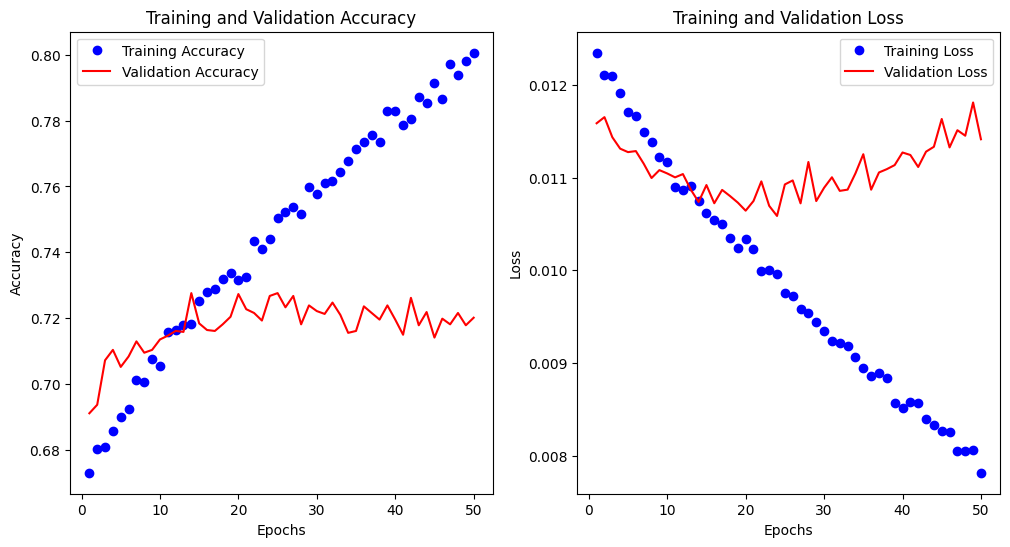

In [87]:
plot_acc_loss(history)